In [12]:
import argparse
import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.optim
from torch.nn.utils import clip_grad_norm_
from data import TrainStation
from motsynth import MOTSynth, MOTSynthBlackBG
from log_utils import log_summary
from utils import save_ckpt, load_ckpt, print_scalor
from utils import spatial_transform, visualize
from common import *
import parse
import pickle
import json
import skimage.transform as st
from pycocotools import mask as coco_mask
from tensorboardX import SummaryWriter
from skimage.transform import resize
from skimage import img_as_bool
from scalor import SCALOR
from matplotlib import pyplot as plt

In [17]:
a = torch.randn(4, 49, 1, 128, 128)
# a = torch.rand(4,4)

In [2]:
# a.repeat(8,1)

In [18]:
my_list = []
for i in range(5):
    my_list.append(torch.randn(4, 49, 1, 128, 128))

In [7]:
(a > 0.5).float()

tensor([[1., 1., 0., 1.],
        [0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [1., 0., 1., 0.]])

In [21]:
torch.rand(4, 49, 1, 128, 128).shape

torch.Size([4, 49, 1, 128, 128])

In [20]:
torch.stack(my_list,0).shape

torch.Size([5, 4, 49, 1, 128, 128])

In [ ]:
torch.stack(my_list,0).shape

In [26]:
a = torch.rand(4, 49, 1, 128, 128)
a = torch.rand(196, 128, 128)
b = torch.rand(134, 128, 128)

In [ ]:
torch.stack([a,b]).shape

In [24]:
torch.flatten(a, 0, 1).shape

torch.Size([196, 1, 128, 128])

In [25]:
a.flatten(0,1).shape

torch.Size([196, 1, 128, 128])

In [3]:
ss = {'size': [1080, 1080], 'counts': 'PRcS1'}

In [8]:
convert_coco_poly_to_mask([ss], 1080, 1080)[0].shape

polys


(1080, 1080, 1)

In [15]:
a  = convert_coco_poly_to_mask([ss], 1080, 1080)[0]

polys


In [34]:
a.transpose(2,0,1).shape

(1, 1080, 1080)

In [ ]:
coco_mask.frPyObjects(a.astype(np.double).squeeze(), 1080, 1080)

In [36]:
len(coco_mask.frPyObjects(a.transpose(2,0,1).astype(np.double).squeeze(), 1080, 1080))

ValueError: Buffer has wrong number of dimensions (expected 2, got 3)

In [17]:
a.shape

(1080, 1080, 1)

In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        if isinstance(polygons['counts'], list):
            print("counts")
            rles = coco_mask.frPyObjects(polygons, height, width)
        
        else:
            print("polys")
            rles = [polygons]

        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        #mask = torch.as_tensor(mask, dtype=torch.uint8)
        #mask = mask.any(dim=2)
        masks.append(mask)
    # if masks:
    #     masks = torch.stack(masks, dim=0)
    # else:
    #     masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks

In [3]:
def get_log_disc_dict(log_disc_list, j = 0, cs = 8, prefix="train", bs = 2):
    
    log_disc = {
        'z_what': log_disc_list[j]['z_what'].view(-1, cs * cs, z_what_dim),
        'z_where_scale':
            log_disc_list[j]['z_where'].view(-1, cs * cs, z_where_scale_dim + z_where_shift_dim)[:, :,
            :z_where_scale_dim],
        'z_where_shift':
            log_disc_list[j]['z_where'].view(-1, cs * cs, z_where_scale_dim + z_where_shift_dim)[:, :,
            z_where_scale_dim:],
        'z_pres': log_disc_list[j]['z_pres'].permute(0, 2, 3, 1),
        'z_pres_probs': torch.sigmoid(log_disc_list[j]['z_pres_logits']).permute(0, 2, 3, 1),
        'z_what_std': log_disc_list[j]['z_what_std'].view(-1, cs * cs, z_what_dim),
        'z_what_mean': log_disc_list[j]['z_what_mean'].view(-1, cs * cs, z_what_dim),
        'z_where_scale_std':
            log_disc_list[j]['z_where_std'].permute(0, 2, 3, 1)[:, :, :z_where_scale_dim],
        'z_where_scale_mean':
            log_disc_list[j]['z_where_mean'].permute(0, 2, 3, 1)[:, :, :z_where_scale_dim],
        'z_where_shift_std':
            log_disc_list[j]['z_where_std'].permute(0, 2, 3, 1)[:, :, z_where_scale_dim:],
        'z_where_shift_mean':
            log_disc_list[j]['z_where_mean'].permute(0, 2, 3, 1)[:, :, z_where_scale_dim:],
        'glimpse': log_disc_list[j]['x_att'].view(-1, cs * cs, 3, glimpse_size, glimpse_size) \
            if prefix != 'generate' else None,
        'glimpse_recon': log_disc_list[j]['y_att'].view(-1, cs * cs, 3, glimpse_size, glimpse_size),
        'prior_z_pres_prob': log_disc_list[j]['prior_z_pres_prob'].unsqueeze(0),
        'o_each_cell': spatial_transform(log_disc_list[j]['o_att'], log_disc_list[j]['z_where'],
                                         (cs * cs * bs, 3, img_h, img_w),
                                         inverse=True).view(-1, cs * cs, 3, img_h, img_w),
        'alpha_hat_each_cell': spatial_transform(log_disc_list[j]['alpha_att_hat'],
                                                 log_disc_list[j]['z_where'],
                                                 (cs * cs * bs, 1, img_h, img_w),
                                                 inverse=True).view(-1, cs * cs, 1, img_h, img_w),
        'alpha_each_cell': spatial_transform(log_disc_list[j]['alpha_att'], log_disc_list[j]['z_where'],
                                             (cs * cs * bs, 1, img_h, img_w),
                                             inverse=True).view(-1, cs * cs, 1, img_h, img_w),
        'y_each_cell': (log_disc_list[j]['y_each_cell'] * log_disc_list[j]['z_pres'].
                        view(-1, 1, 1, 1)).view(-1, cs * cs, 3, img_h, img_w),
        'z_depth': log_disc_list[j]['z_depth'].view(-1, cs * cs, z_depth_dim),
        'z_depth_std': log_disc_list[j]['z_depth_std'].view(-1, cs * cs, z_depth_dim),
        'z_depth_mean': log_disc_list[j]['z_depth_mean'].view(-1, cs * cs, z_depth_dim),
        'z_pres_logits': log_disc_list[j]['z_pres_logits'].permute(0, 2, 3, 1),
        'z_pres_y': log_disc_list[j]['z_pres_y'].permute(0, 2, 3, 1)
    }
    return log_disc

def get_log_prop_dict(log_prop_list, j = 0, cs = 8, prefix="train", bs = 2):
    if log_prop_list[j]:
        log_prop = {
            'z_what': log_prop_list[j]['z_what'].view(bs, -1, z_what_dim),
            'z_where_scale':
                log_prop_list[j]['z_where'].view(bs, -1, z_where_scale_dim + z_where_shift_dim)[:, :,
                :z_where_scale_dim],
            'z_where_shift':
                log_prop_list[j]['z_where'].view(bs, -1, z_where_scale_dim + z_where_shift_dim)[:, :,
                z_where_scale_dim:],
            'z_pres': log_prop_list[j]['z_pres'],
            'z_what_std': log_prop_list[j]['z_what_std'].view(bs, -1, z_what_dim),
            'z_what_mean': log_prop_list[j]['z_what_mean'].view(bs, -1, z_what_dim),
            'z_where_bias_scale_std':
                log_prop_list[j]['z_where_bias_std'][:, :, :z_where_scale_dim],
            'z_where_bias_scale_mean':
                log_prop_list[j]['z_where_bias_mean'][:, :, :z_where_scale_dim],
            'z_where_bias_shift_std':
                log_prop_list[j]['z_where_bias_std'][:, :, z_where_scale_dim:],
            'z_where_bias_shift_mean':
                log_prop_list[j]['z_where_bias_mean'][:, :, z_where_scale_dim:],
            'z_pres_probs': torch.sigmoid(log_prop_list[j]['z_pres_logits']),
            'glimpse': log_prop_list[j]['glimpse'],
            'glimpse_recon': log_prop_list[j]['glimpse_recon'],
            'prior_z_pres_prob': log_prop_list[j]['prior_z_pres_prob'],
            'prior_where_bias_scale_std':
                log_prop_list[j]['prior_where_bias_std'][:, :, :z_where_scale_dim],
            'prior_where_bias_scale_mean':
                log_prop_list[j]['prior_where_bias_mean'][:, :, :z_where_scale_dim],
            'prior_where_bias_shift_std':
                log_prop_list[j]['prior_where_bias_std'][:, :, z_where_scale_dim:],
            'prior_where_bias_shift_mean':
                log_prop_list[j]['prior_where_bias_mean'][:, :, z_where_scale_dim:],

            'lengths': log_prop_list[j]['lengths'],
            'z_depth': log_prop_list[j]['z_depth'],
            'z_depth_std': log_prop_list[j]['z_depth_std'],
            'z_depth_mean': log_prop_list[j]['z_depth_mean'],

            'y_each_obj': log_prop_list[j]['y_each_obj'],
            'alpha_hat_each_obj': log_prop_list[j]['alpha_map'],

            'z_pres_logits': log_prop_list[j]['z_pres_logits'],
            'z_pres_y': log_prop_list[j]['z_pres_y'],
            'o_each_obj':
                spatial_transform(log_prop_list[j]['o_att'].view(-1, 3, glimpse_size, glimpse_size),
                                  log_prop_list[j]['z_where'].view(-1, (z_where_scale_dim +
                                                                        z_where_shift_dim)),
                                  (log_prop_list[j]['o_att'].size(1) * bs, 3, img_h, img_w),
                                  inverse=True).view(bs, -1, 3, img_h, img_w),
            'z_where_bias_scale':
                log_prop_list[j]['z_where_bias'].view(bs, -1, z_where_scale_dim + z_where_shift_dim)
                [:, :, :z_where_scale_dim],
            'z_where_bias_shift':
                log_prop_list[j]['z_where_bias'].view(bs, -1, z_where_scale_dim + z_where_shift_dim)
                [:, :, z_where_scale_dim:],
        }
    return log_prop

def calculate_IoU(pred, targed):
    '''
    Calculates the Intersection over Union(Intersection over Union).
    '''
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score

def predict(log_disc_list, log_prop_list, video_id, indice):
    
    prediction ={
                "video_id" : video_id, 
                "category_id" : 1, 
                "segmentations" : [None for i in range(360)], 
                "score" : [], 
            }
    import copy

    obj_idx_dict = {}
    start_idx = indice * 10
    for j in range(10):
        
        log_disc = get_log_disc_dict(log_disc_list=log_disc_list, j = j, cs = 8, prefix="train", bs = 1)
        discovery_ids= log_disc_list[j]["ids"][0].view(-1)
        discovery_pres_scores = log_disc_list[j]["z_pres"][0].view(-1)
        discovered_object_indices = np.where(discovery_pres_scores > 0.5)[0]
        discovered_object_masks = log_disc['alpha_hat_each_cell'][0].squeeze(1)[discovered_object_indices]
        
        for k, discovered_obj_indice in enumerate(discovered_object_indices):
            discovered_obj_id = int(discovery_ids[discovered_obj_indice].item())
            discovery_z_pres = discovery_pres_scores[discovered_obj_indice].item()
            
            if discovered_obj_id in obj_idx_dict:
                
                mask = copy.deepcopy(discovered_object_masks[k].numpy())
#                 mask[mask > 0.005] = 1
#                 mask = st.resize(mask, (1080, 1080))
#                 mask[mask>0.00005] = 1
                mask = mask >= 0.01
                mask = img_as_bool(resize(mask, (1080, 1080)))
                seg = coco_mask.encode(np.asfortranarray(np.uint8(mask)))
                seg["counts"] = seg["counts"].decode("utf-8")
                
                obj_idx_dict[discovered_obj_id]["segmentations"][start_idx + j] = copy.deepcopy(seg)
                
                obj_idx_dict[discovered_obj_id]["score"].append(discovery_z_pres)
            else:
                obj_idx_dict[discovered_obj_id] = copy.deepcopy(prediction)
                mask = copy.deepcopy(discovered_object_masks[k].numpy())
#                 mask[mask > 0.005] = 1
#                 mask = st.resize(mask, (1080, 1080))
#                 mask[mask>0.00005] = 1
                mask = mask >= 0.08
                mask = img_as_bool(resize(mask, (1080, 1080)))
                seg = coco_mask.encode(np.asfortranarray(np.uint8(mask)))
                seg["counts"] = seg["counts"].decode("utf-8")
                
                obj_idx_dict[discovered_obj_id]["segmentations"][start_idx + j] = copy.deepcopy(seg)
                obj_idx_dict[discovered_obj_id]["score"].append(discovery_z_pres)
                
        if log_prop_list[j]:
            log_prop = get_log_prop_dict(log_prop_list=log_prop_list, j = j, cs = 8, prefix="train", bs = 1)
            propagated_ids = log_prop_list[j]["ids"][0].view(-1)
            propagation_pres_scores = log_prop_list[j]["z_pres"][0].view(-1)
            propagated_object_indices = np.where(propagation_pres_scores > 0.5)[0]
            # print(propagated_ids[propagated_object_indices])
            propagated_object_masks = log_prop['alpha_hat_each_obj'][0].squeeze(1)[propagated_object_indices]
            
            for k, propagated_obj_indice in enumerate(propagated_object_indices):
                propagated_obj_id = int(propagated_ids[propagated_obj_indice].item())
                propagated_z_pres = propagation_pres_scores[propagated_obj_indice].item()
                if not propagated_obj_id == 0:
                    if discovered_obj_id in obj_idx_dict:
                        
                        mask = copy.deepcopy(propagated_object_masks[k].numpy())
#                         mask[mask > 0.005] = 1
#                         mask = st.resize(mask, (1080, 1080))
#                         mask[mask>0.00005] = 1
                        mask = mask >= 0.01
                        mask = img_as_bool(resize(mask, (1080, 1080)))
                        seg = coco_mask.encode(np.asfortranarray(np.uint8(mask)))
                        seg["counts"] = seg["counts"].decode("utf-8")

                        obj_idx_dict[propagated_obj_id]["segmentations"][start_idx + j] = copy.deepcopy(seg)
                        obj_idx_dict[propagated_obj_id]["score"].append(propagated_z_pres)
                    else:
                        raise Exception("ahahahah")
                        obj_idx_dict[propagated_obj_id] = copy.deepcopy(prediction)
                        obj_idx_dict[propagated_obj_id]["segmentations"][start_idx + j] = propagated_object_masks[k].numpy()
                        obj_idx_dict[propagated_obj_id]["score"].append(propagated_z_pres)
    
    

    return obj_idx_dict

In [5]:
d_path = "example_viz/preds_gradient_bs1.pickle"

import pickle
with open(d_path, 'rb') as handle:
    preds = pickle.load(handle)

In [6]:
imgs, y_seq, log_like, kl_z_what, kl_z_where, kl_z_depth, \
kl_z_pres, kl_z_bg, log_imp, counting, \
log_disc_list, log_prop_list, scalor_log_list = preds

In [15]:
log_disc = get_log_disc_dict(log_disc_list=log_disc_list, j = 0, cs = 8, prefix="train", bs = 1)


In [135]:
id_dict = predict(log_disc_list, log_prop_list, 1, 0)

In [136]:
id_dict.keys()

dict_keys([11, 14, 15, 16, 20, 22, 24, 28, 32, 36, 38, 44, 45, 46, 54, 63, 69, 74, 76, 82, 92, 105, 109, 118, 128, 150])

In [137]:
masks = convert_coco_poly_to_mask([a for a in id_dict[20]["segmentations"] if a], 1080, 1080)

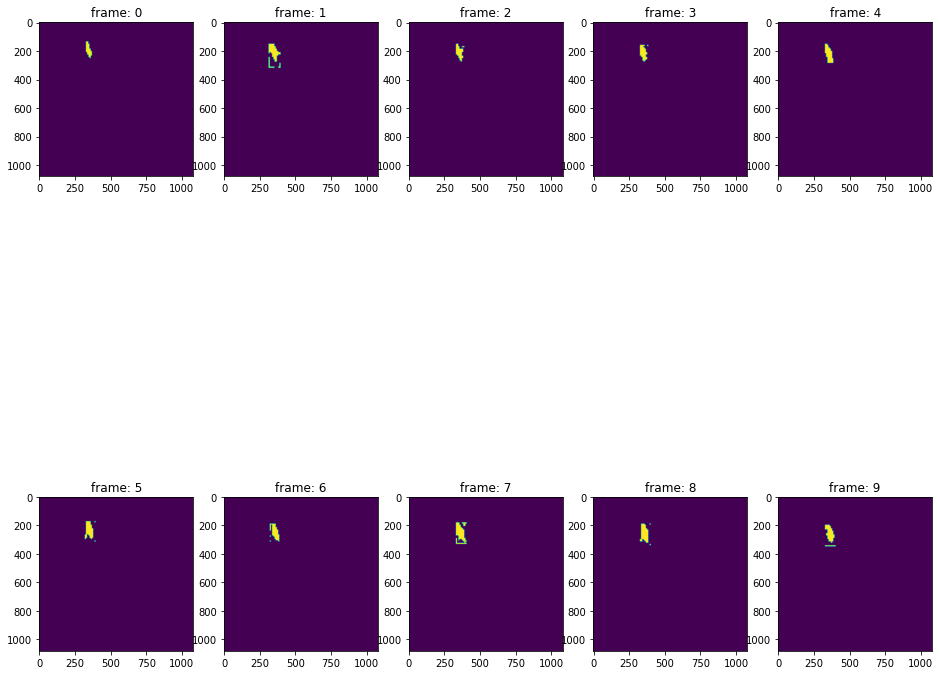

In [138]:
visualize_masks(masks)

In [50]:
# example_masks = id_dict[14]

In [32]:
# id_dict[14]["segmentations"]

In [33]:
log_disc["alpha_each_cell"].shape

torch.Size([1, 64, 1, 128, 128])

In [34]:
z_pres = (log_disc["z_pres_probs"].view(-1) > 0.5).numpy()

In [35]:
(-z_pres).argsort()

TypeError: The numpy boolean negative, the `-` operator, is not supported, use the `~` operator or the logical_not function instead.

In [36]:
z_pres = log_disc["z_pres_probs"].view(-1).numpy()

In [37]:
masks_np = log_disc["alpha_each_cell"].squeeze().numpy()

In [51]:
masks.shape

AttributeError: 'list' object has no attribute 'shape'

In [38]:
(-z_pres).argsort()

array([21, 27, 14, 37, 44, 35, 15, 23, 13, 31, 10, 43, 45, 12, 19, 62, 53,
       18,  5, 63, 22, 38,  6, 36,  8, 52, 26, 57, 16,  7, 56, 24,  3,  4,
       11, 40, 59, 47,  9, 29, 20, 34, 48, 60, 41, 46, 58, 39, 55, 32, 28,
       30, 50,  0,  2, 54, 49, 61, 17,  1, 33, 42, 51, 25])

In [39]:
z_pres[z_pres > 0.7].shape

(14,)

In [44]:
masks_np.shape

(64, 128, 128)

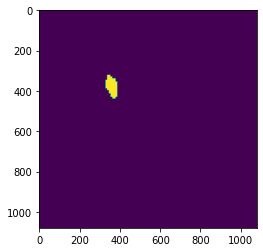

In [40]:
from skimage.transform import resize
from skimage import img_as_bool
image = masks_np[27]
# image[image>=0.008] = True
# image[image<0.008] = False
bool_arr = image >= 0.03
resized = img_as_bool(resize(bool_arr, (1080, 1080)))

plt.imshow(resized)
plt.show()

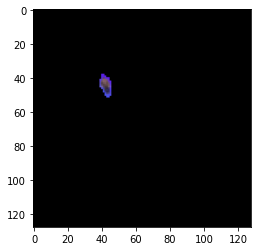

In [42]:
masked_img = bool_arr * imgs[0,0].cpu().numpy()
plt.imshow(masked_img.transpose(1,2,0))
plt.show()

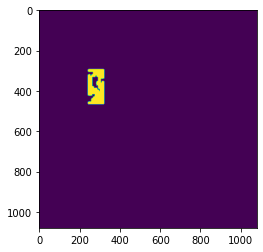

In [43]:
mask = masks_np[26]

mask[mask > 0.005] = 1
mask = st.resize(mask, (1080, 1080))
bool_arr = mask > 0.1
resized = img_as_bool(resize(bool_arr, (1080, 1080)))

plt.imshow(resized)
plt.show()

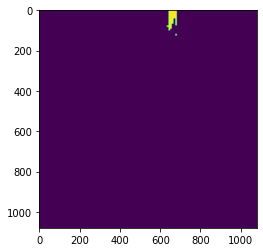

In [248]:
plt.imshow(masks[7].squeeze())
plt.show()

In [252]:
masked_img = masks[7] * imgs[0,0].cpu().numpy()
plt.imshow(masked_img.transpose(1,2,0))
plt.show()

ValueError: operands could not be broadcast together with shapes (1080,1080,1) (3,128,128) 

In [101]:
masks_np[26].shape

(128, 128)

In [147]:
import numpy as np
from matplotlib import pyplot as plt


image = masks_np[26]
binary = image > 0.008


In [83]:
binary

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [88]:
imgs.shape

torch.Size([1, 10, 3, 128, 128])

In [89]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

In [91]:
imgs[0,0].shape

torch.Size([3, 128, 128])

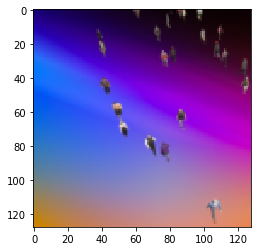

In [93]:
show(imgs[0,0].cpu())

In [127]:
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [86]:
bool_arr.shape

(1080, 1080)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

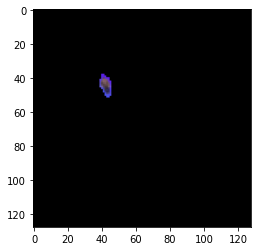

In [253]:
masked_img = bool_arr * imgs[0,0].cpu().numpy()
plt.imshow(masked_img.transpose(1,2,0))
plt.show()

In [254]:
bool_arr.shape

(128, 128)

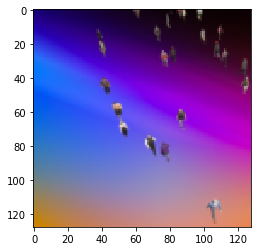

In [157]:
show(imgs[0,0].cpu())

In [85]:
imgs[0,0].cpu().numpy().shape

(3, 128, 128)

In [52]:
len(masks)

10

In [66]:
from matplotlib.pyplot import figure

figure(figsize=(15, 15), dpi=120)

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

In [88]:
imgs.shape

torch.Size([1, 10, 3, 128, 128])

In [78]:
id_dict.keys()

dict_keys([11, 14, 15, 16, 20, 22, 24, 28, 32, 36, 38, 44, 45, 46, 54, 63, 69, 74, 76, 82, 92, 105, 109, 118, 128, 150])

In [81]:
masks = convert_coco_poly_to_mask([a for a in id_dict[20]["segmentations"] if a], 1080, 1080)
print(len(masks))

10


In [82]:
# fig, axs = plt.subplots(2, 2, figsize=(8, 8))


# for num, img in enumerate(masks):
# #     img = PIL.Image.open(x)
    
#     plt.subplot(2,5,num+1)
#     plt.title(f"frame: {num}")
#     plt.axis('off')
#     plt.imshow(img.squeeze())

In [7]:
def visualize_masks(masks):
    fig, axs = plt.subplots(2, 5, figsize=(16, 16))


    for num, img in enumerate(masks):
    #     img = PIL.Image.open(x)

    #     axs.plot(2,5,num//5+num)
    #     axs.title(f"frame: {num}")
    #     axs.axis('off')
        axs[num//5, num%5].imshow(img.squeeze())
        axs[num//5, num%5].set_title(f"frame: {num}")
    #     axs.imshow(img.squeeze())

In [8]:
def visualize_masks_in_images(masks, real_image):
    fig, axs = plt.subplots(2, 5, figsize=(16, 16))
    

    for num, mask in enumerate(masks):
        masked_img = mask.squeeze() * real_image
    #     img = PIL.Image.open(x)

    #     axs.plot(2,5,num//5+num)
    #     axs.title(f"frame: {num}")
    #     axs.axis('off')
        axs[num//5, num%5].imshow(masked_img)
        axs[num//5, num%5].set_title(f"frame: {num}")
    #     axs.imshow(img.squeeze())

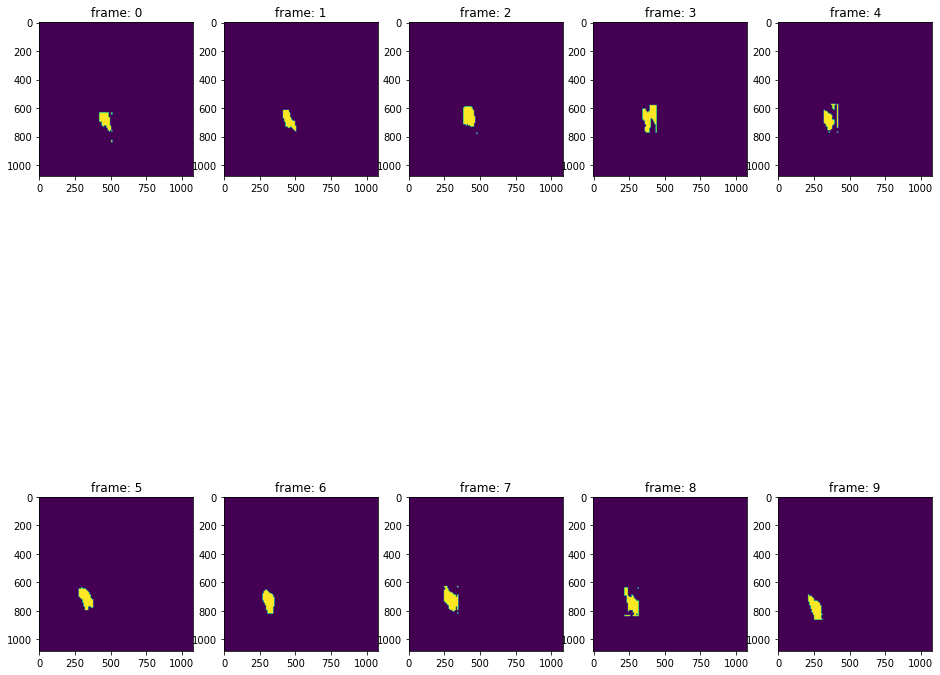

In [219]:
visualize_masks(masks)

In [220]:
import json
with open('predictions_model_gradient_3.json', 'r') as f:
    preds = json.loads(f.read())

In [229]:
masks = convert_coco_poly_to_mask([a for a in preds[13]["segmentations"] if a], 1080, 1080)

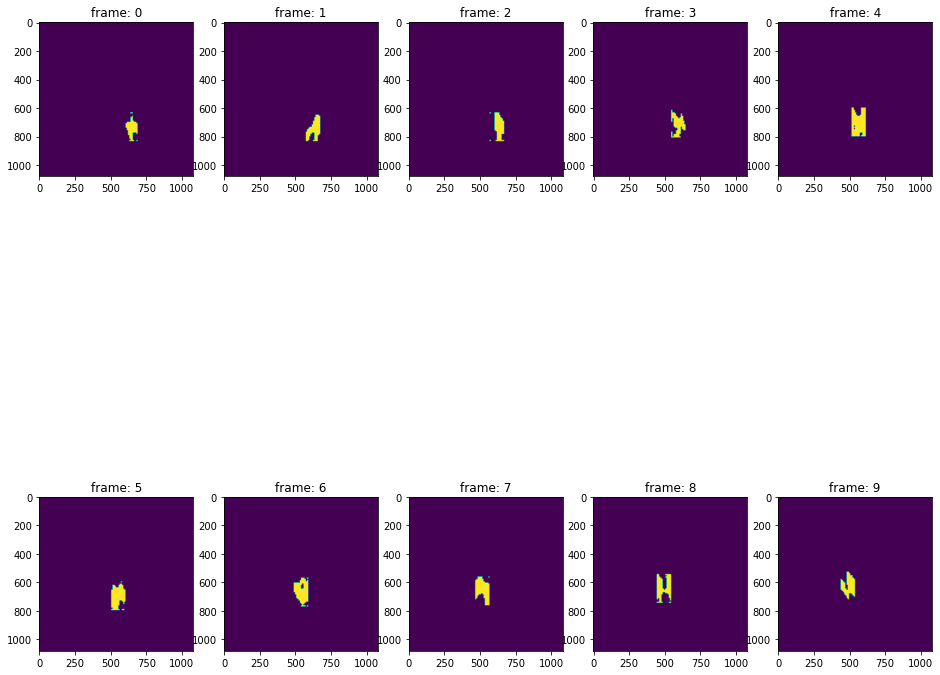

In [230]:
visualize_masks(masks)

In [231]:
from PIL import Image

In [9]:
def visualize_masks_in_images(masks, frames):
    fig, axs = plt.subplots(2, 5, figsize=(16, 16))
    

    for num, mask in enumerate(masks):
        real_frame = frames[0]
        masked_img = mask.squeeze() * real_frame
    #     img = PIL.Image.open(x)

    #     axs.plot(2,5,num//5+num)
    #     axs.title(f"frame: {num}")
    #     axs.axis('off')
        axs[num//5, num%5].imshow(masked_img.transpose(1,2,0))
        axs[num//5, num%5].set_title(f"frame: {num}")
    #     axs.imshow(img.squeeze())
    
def visualize_real_frames(frames):
    fig, axs = plt.subplots(2, 5, figsize=(16, 16))
    
    for num, mask in enumerate(masks):
        real_frame = frames[0]
    #     img = PIL.Image.open(x)

    #     axs.plot(2,5,num//5+num)
    #     axs.title(f"frame: {num}")
    #     axs.axis('off')
        axs[num//5, num%5].imshow(real_frame.transpose(1,2,0))
        axs[num//5, num%5].set_title(f"frame: {num}")
    #     axs.imshow(img.squeeze())

In [233]:
images_list = []
for i in range(10):
    print(str(i*50 + 1800))
    img = Image.open(f"rand_static_bg_frames_td_gradient/{str(i*50 + 1800).zfill(6)}.jpeg")
    img = img.crop(box=(0, 0, 1920 - (840 - 0), 1080))
    images_list.append(np.transpose(np.array(img), (2, 0, 1)))

1800
1850
1900
1950
2000
2050
2100
2150
2200
2250


In [226]:
str(i*50 + 1800)

'2250'

In [201]:
images_list[0].shape

(3, 1080, 1080)

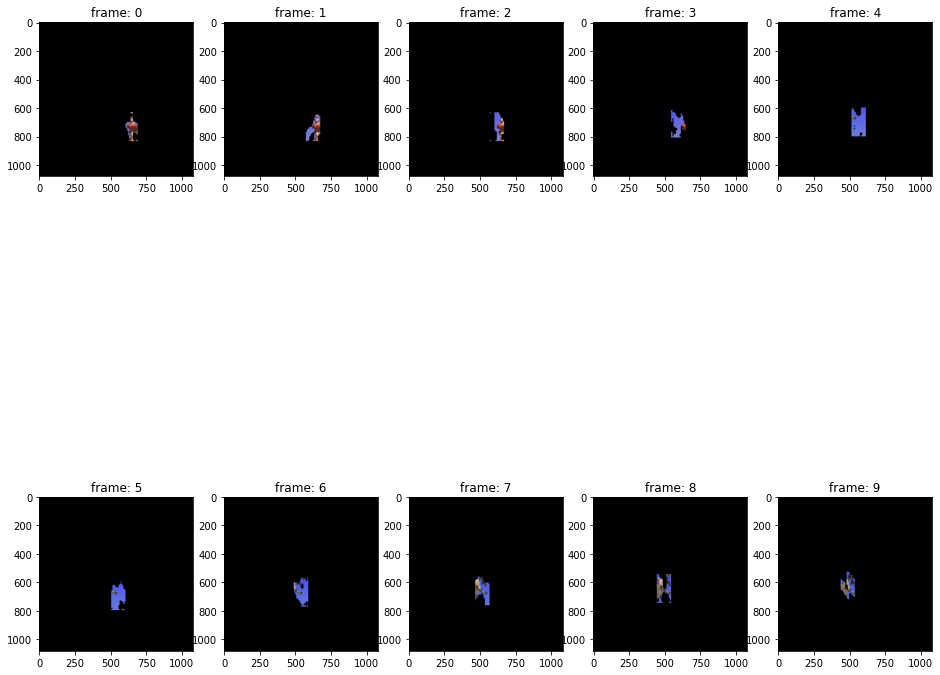

In [234]:
visualize_masks_in_images(masks, images_list)

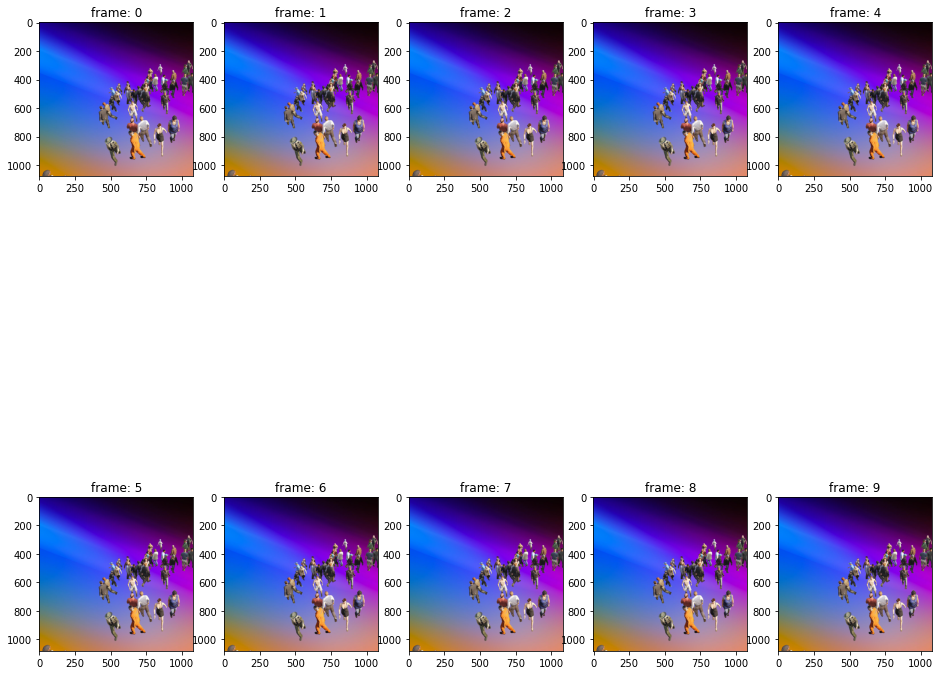

In [213]:
visualize_real_frames(images_list)

In [ ]:
visualize_real_frames(images_list)

In [10]:
gt_data_path = "evaluation/gt_data_eval.json"
with open(gt_data_path) as fp:
    gt_data = json.load(fp)

In [11]:
gt_data.keys()

dict_keys(['info', 'videos', 'annotations', 'categories'])

In [14]:
masks = convert_coco_poly_to_mask([a for a in gt_data["annotations"][0]["segmentations"] if a], 1080, 1080)

In [15]:
len(masks)

360

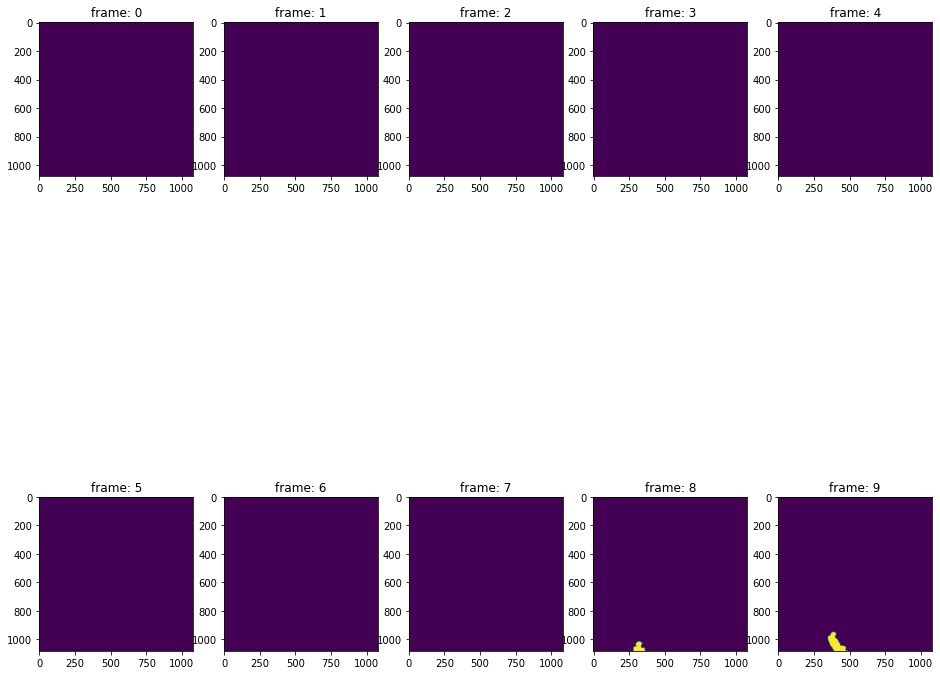

In [16]:
visualize_masks(masks[0:10])

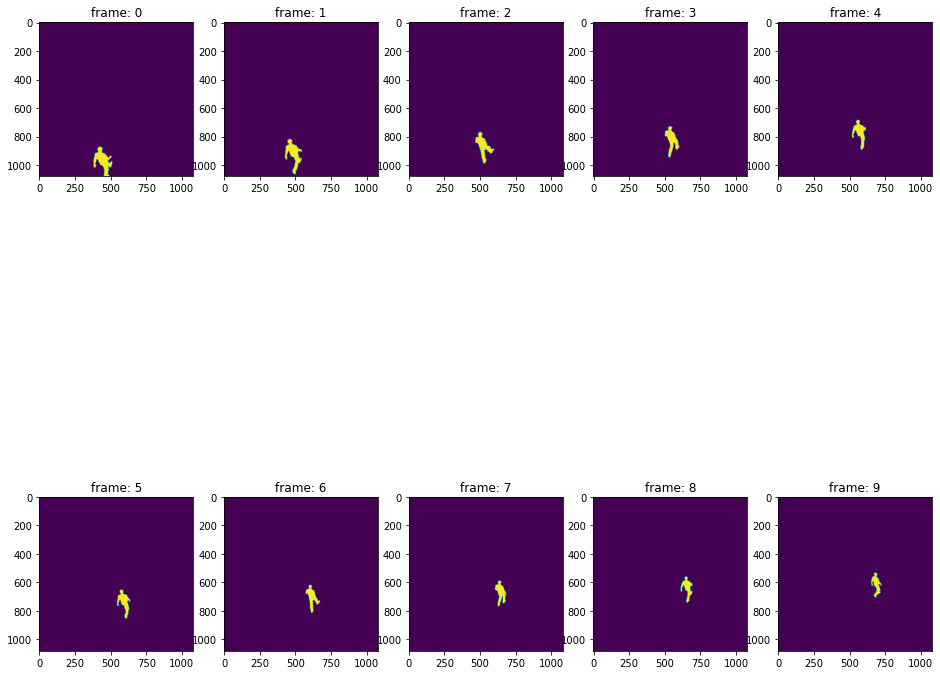

In [17]:
visualize_masks(masks[10:20])

In [18]:
def calculate_IoU(pred, target):
    '''
    Calculates the Intersection over Union(Intersection over Union).
    '''
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score

In [24]:
for i in range(10):
    print(calculate_IoU(masks[i+10], masks[i+11]))

# calculate_IoU(masks[12], masks[13])

0.10476696321869605
0.1556584571544881
0.08818563102565499
0.21972467912482543
0.1925811219821215
0.30363119143239625
0.15132458140083327
0.29962157048249766
0.15251718372654655
0.07094594594594594


In [93]:
gt_data_path = "evaluation/predictions_model_gradient_4_threshold003_last_version.json"
with open(gt_data_path) as fp:
    ppp = json.load(fp)

In [94]:
masks = convert_coco_poly_to_mask([a for a in ppp[799]["segmentations"] if a], 1080, 1080)

In [95]:
len(masks)

43

In [33]:
len([a for a in ppp[0]["segmentations"] if a])

121

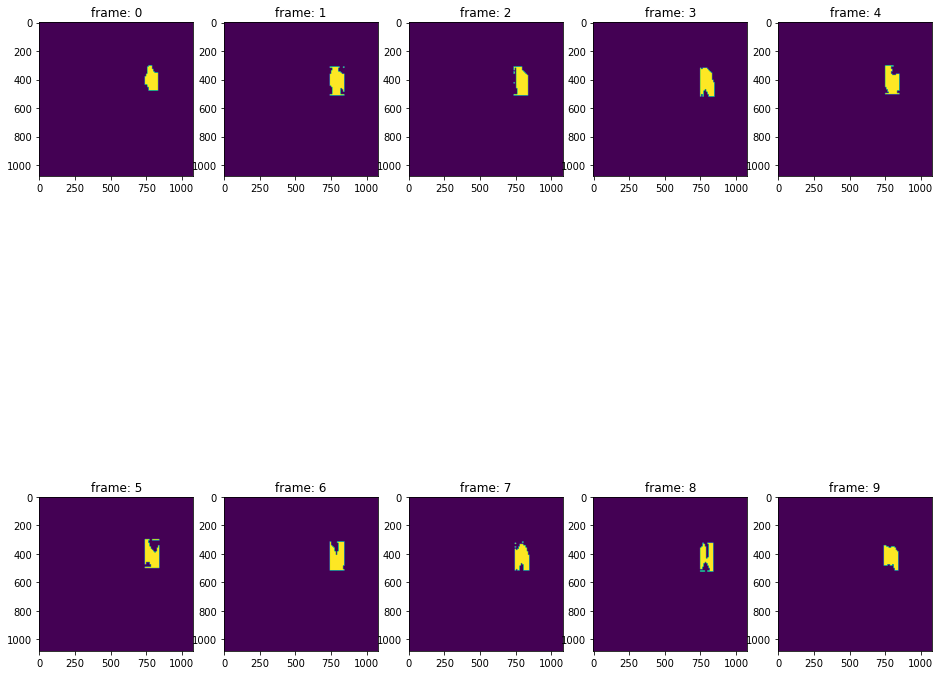

In [73]:
visualize_masks(masks[0:10])

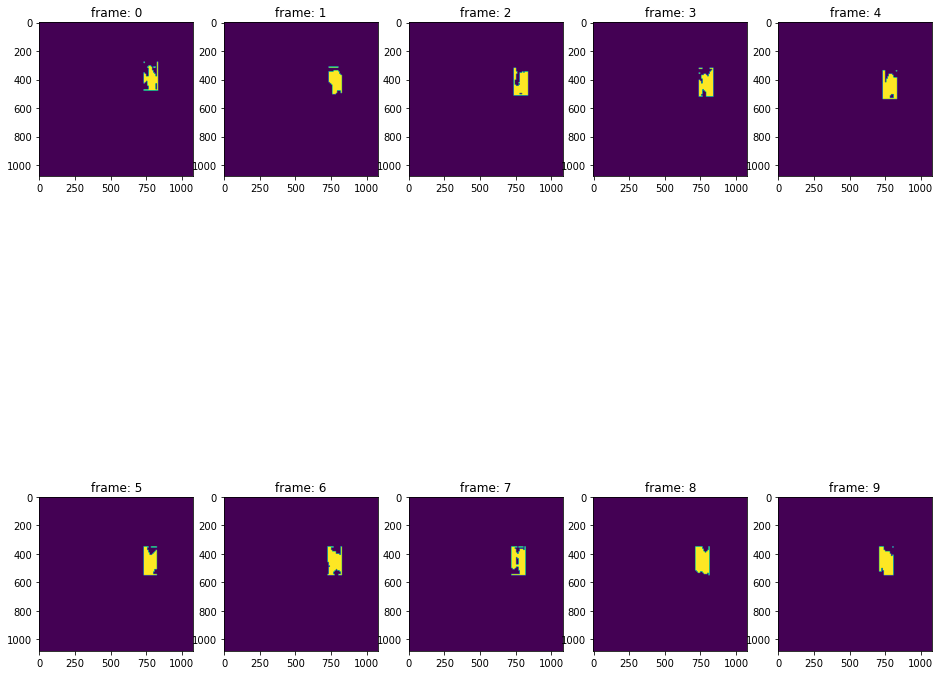

In [35]:
visualize_masks(masks[10:20])

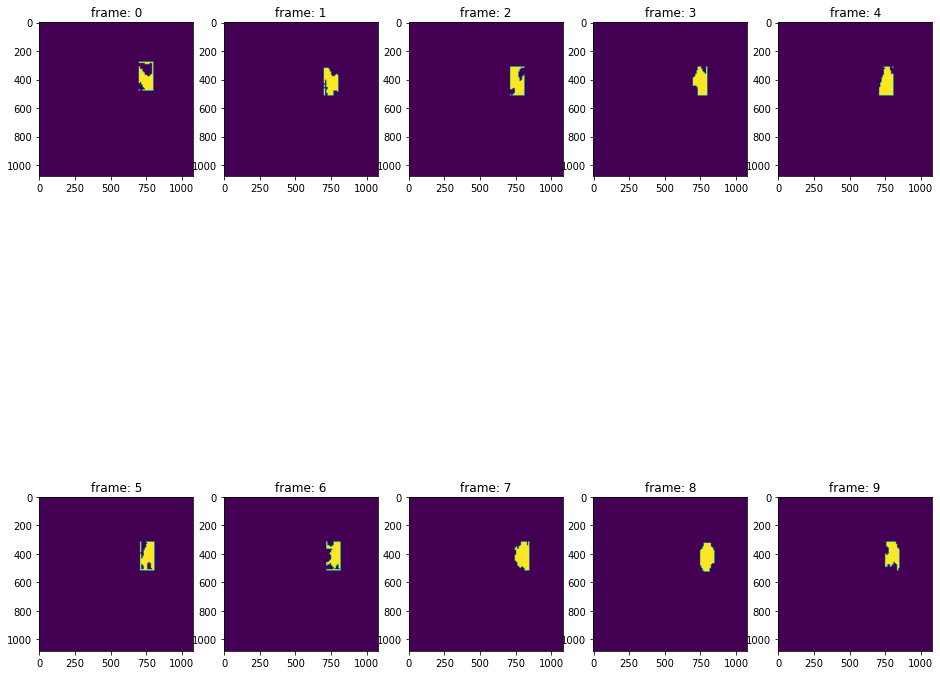

In [36]:
visualize_masks(masks[20:30])

In [6]:
len(masks_list)

43

ERROR! Session/line number was not unique in database. History logging moved to new session 430


In [39]:
masks_list = []
counter = 0
for i in range(1000):
    masks = convert_coco_poly_to_mask([a for a in ppp[i+4000]["segmentations"] if a], 1080, 1080)
    if len(masks) > 80:
        masks_list.append(masks)
        counter += 1
        if counter > 5:
            break


In [4]:
gt_data_path = "evaluation/predictions_model_gradient_4_threshold003_last_version.json"
with open(gt_data_path) as fp:
    ppp = json.load(fp)

In [7]:
len(masks_list[0])

209

In [40]:
import numpy as np
from PIL import Image

masks = masks_list[1]

# imgs = np.random.randint(0, 255, (100, 50, 50, 3), dtype=np.uint8)
imgs = [Image.fromarray(img.squeeze()*255) for img in masks]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=100, loop=0)

In [42]:
len(ppp)

5281

In [ ]:
# from IPython.display import Image, Video
# Image(url='images_heavily_blurred_bw/000000.jpeg') 

In [ ]:
# from IPython.display import Image, Video
# Image(url='images_blurred_birdview_rbg/000000.jpeg') 

In [41]:
from IPython.display import Image
Image(url='array.gif') 

In [76]:
masks[0].squeeze().all()

False